In [ ]:
import os
import pickle
from pathlib import Path

import pandas as pd
import plotly.io as pio
import torch

from project.utils.dataset import derive_features
from project.utils.modeling import predict_model
from project.utils.visuals import plot_target_vs_predicted_heartrate

pio.renderers.default = "svg"

In [5]:
CURRENT_DIR = Path(os.getcwd())

DATASET_CACHE_DIR = CURRENT_DIR.parent / "scripts" / "dataset" / ".cache"
MODEL_CACHE_DIR = CURRENT_DIR.parent / "scripts" / "modelling" / ".cache"

TEST_DATASET_PATH = DATASET_CACHE_DIR / "test_raw.parquet"
STANDARD_SCALER_PATH = DATASET_CACHE_DIR / "user_standard_scaler.pkl"
STATIC_ENCODER_PATH = DATASET_CACHE_DIR / "static_ordinal_encoder.pkl"

MODEL_PATH = MODEL_CACHE_DIR / "fitrec_model.pt"

# THESE SHOULD MATCH THE ONES USED DURING TRAINING
dataset_arguments = {
    "numerical_columns": [
        "time_elapsed_standardized",
        "altitude_standardized",
        "derived_speed_standardized",
        "derived_distance_standardized",
    ],
    "categorical_columns": ["userId_idx", "sport_idx", "gender_idx"],
    "heartrate_input_column": "heart_rate_standardized",
    "heartrate_output_column": "heart_rate",
    "workout_id_column": "id",
    "use_heartrate_input": True,
}

In [6]:
if not TEST_DATASET_PATH.exists():
    raise FileNotFoundError(
        f"Source dataset not found at {TEST_DATASET_PATH}. "
        "Please run the scripts/dataset/3_dataset_splitting.py script first."
    )

if not STANDARD_SCALER_PATH.exists():
    raise FileNotFoundError(
        f"Standard scaler object not found at {STANDARD_SCALER_PATH}. "
        "Please run the scripts/dataset/4_dataset_preprocessing.py script first."
    )

if not STATIC_ENCODER_PATH.exists():
    raise FileNotFoundError(
        f"Static encoder object not found at {STATIC_ENCODER_PATH}. "
        "Please run the scripts/dataset/4_dataset_preprocessing.py script first."
    )

if not MODEL_PATH.exists():
    raise FileNotFoundError(
        f"No model found at {MODEL_PATH}. "
        "Please run the scripts/modelling/training.py script first."
    )

In [7]:
# LOADING THE INPUTS
test_df = pd.read_parquet(TEST_DATASET_PATH, dtype_backend="pyarrow")

standard_scaler = pickle.load(open(STANDARD_SCALER_PATH, "rb"))
static_encoder = pickle.load(open(STATIC_ENCODER_PATH, "rb"))

model = torch.load(MODEL_PATH, weights_only=False)

In [ ]:
# DO YOUR ERROR INJECTION HERE
# DO YOUR ERROR INJECTION HERE

In [12]:
# DERIVE THE DISTANCE AND SPEED COLUMNS
test_df = derive_features(test_df)

In [13]:
# PREPROCESSING THE TEST DATA
test_df = standard_scaler.transform(test_df)
test_df = static_encoder.transform(test_df)

In [14]:
# PERFORMING INFERENCE

y_preds = predict_model(model, test_df, dataset_args=dataset_arguments, n_workers=8)
test_df["predicted_heart_rate"] = list(y_preds)

100%|██████████| 300/300 [00:36<00:00,  8.31it/s]


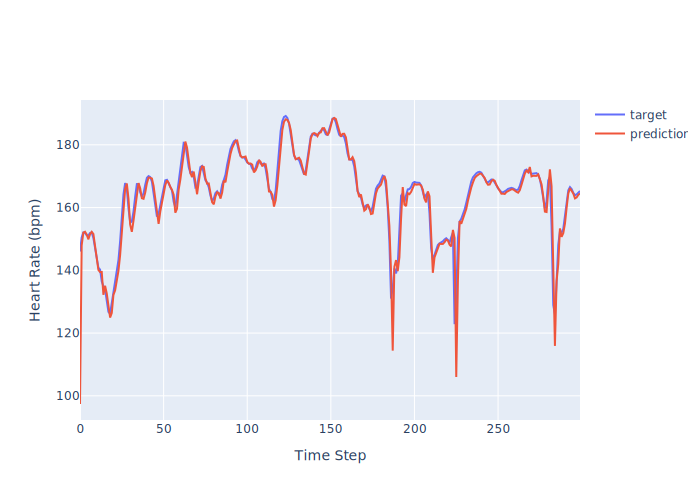

In [15]:
# PLOTTING RESULTS
index = 0

heart_rate = test_df.iloc[index]["heart_rate"]
heart_rate_preds = test_df.iloc[index]["predicted_heart_rate"]

plot_target_vs_predicted_heartrate(heart_rate, heart_rate_preds)